# Выбор локации для скважины

Допустим, работа в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Для начала импортируем необходимые библиотеки и модули

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error


Сохраним в отдельные переменные таблицы с данными по каждому региону

### Регион 0

In [68]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')

Посмотрим на первые 10 строк датафрейма

In [69]:
df0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Изучим общую информацию о таблице

In [70]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


И посмотрим подробнее на основные параметры числовых характеристик

In [71]:
df0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Проверим, что все id встречаются по одному разу

In [72]:
id0_counts = df0['id'].value_counts()
id0_counts

HZww2    2
bxg6G    2
bsk9y    2
fiKDv    2
QcMuo    2
        ..
ev9A3    1
cOE0L    1
KTddw    1
ebfxp    1
Kyr5c    1
Name: id, Length: 99990, dtype: int64

Странно, что некоторые id встречаются дважды. Посмотрим, что это за данные

In [73]:
df0['id'].mode()

0    74z30
1    A5aEY
2    AGS9W
3    HZww2
4    QcMuo
5    Tdehs
6    TtcGQ
7    bsk9y
8    bxg6G
9    fiKDv
dtype: object

In [74]:
strange_id0 = list(df0['id'].value_counts().loc[lambda x : x!=1].index)
strange_id0

['HZww2',
 'bxg6G',
 'bsk9y',
 'fiKDv',
 'QcMuo',
 '74z30',
 'AGS9W',
 'TtcGQ',
 'Tdehs',
 'A5aEY']

In [75]:
df0.loc[df0['id'].isin(strange_id0)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


Для одинаковых id разные значения. Это странно. Лучше удалим эти строки, поскольку они занимают не так много места.

In [76]:
df0 = df0.loc[~df0['id'].isin(strange_id0)]

В данном случае, поскольку модель учится на числовых признаках, столбец id можно убрать.

In [77]:
df0 = df0.drop('id', axis=1)

Посмотрим на изменённый датафрейм

In [78]:
df0

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...
99995,0.971957,0.370953,6.075346,110.744026
99996,1.392429,-0.382606,1.273912,122.346843
99997,1.029585,0.018787,-1.348308,64.375443
99998,0.998163,-0.528582,1.583869,74.040764


Вернёмся к числовым признакам. Посмотрим на зависимость между величинами, чтобы понять, не нужно ли исключать какой-либо параметр

In [79]:
df0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003204,0.143504
f1,-0.440724,1.000000,0.001783,-0.192338
f2,-0.003204,0.001783,1.000000,0.483628
product,0.143504,-0.192338,0.483628,1.000000


Корреляции между f0, f1 и f0 не сильные. Оставляем все три параметра.

Посмотрим на разброс значений по признакам, чтобы понять, нужно ли масштабировать данные

<AxesSubplot:title={'center':'Распределение значений признаков'}, xlabel='Признак', ylabel='Разброс значений'>

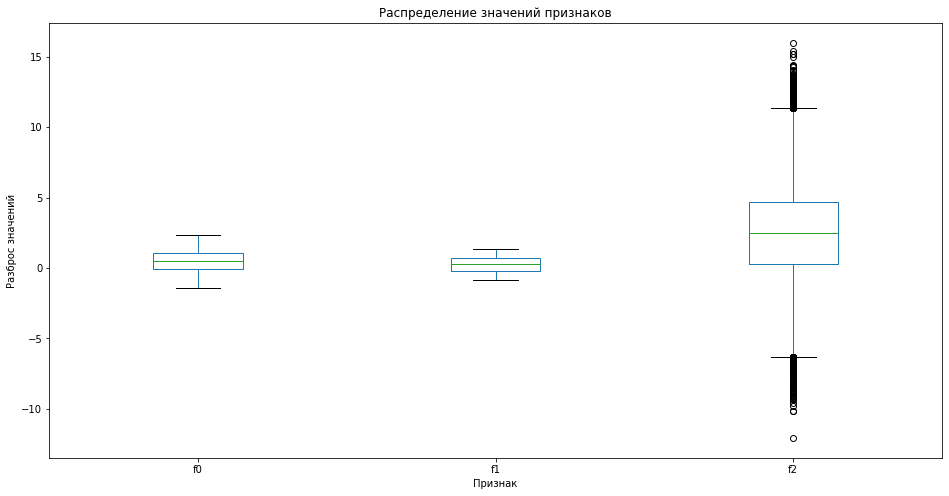

In [80]:
# построение боксплота для признаков f0, f1, f2
df_plot = df0.drop('product', axis=1)

fig, ax = plt.subplots(1)
ax.set_title('Распределение значений признаков')
ax.set_xlabel('Признак')
ax.set_ylabel('Разброс значений')
df_plot.plot(kind='box', figsize=(16,8), ax=ax)

Лучше отмасштабируем данные.

### Регион 1

In [81]:
df1 = pd.read_csv('/datasets/geo_data_1.csv')

Посмотрим на первые 10 строк датафрейма

In [82]:
df1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Изучим общую информацию о таблице

In [83]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


И посмотрим подробнее на основные параметры числовых характеристик

In [84]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Проверим, что все id встречаются по одному разу

In [85]:
id1_counts = df1['id'].value_counts()
id1_counts

5ltQ6    2
LHZR0    2
wt4Uk    2
bfPNe    2
Vzzru    1
        ..
I03Is    1
vtfuW    1
WKLa3    1
PmVvB    1
hGeVC    1
Name: id, Length: 99996, dtype: int64

Странно, что некоторые id встречаются дважды. Посмтрим, что это за данные

In [86]:
df1['id'].mode()

0    5ltQ6
1    LHZR0
2    bfPNe
3    wt4Uk
dtype: object

In [87]:
strange_id1 = list(df1['id'].value_counts().loc[lambda x : x!=1].index)
strange_id1

['5ltQ6', 'LHZR0', 'wt4Uk', 'bfPNe']

In [88]:
df1.loc[df1['id'].isin(strange_id1)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


Для одинаковых id разные значения. Это странно. Лучше удалим эти строки, поскольку они занимают не так много места.

In [89]:
df1 = df1.loc[~df1['id'].isin(strange_id1)]

В данном случае, поскольку модель учится на числовых признаках, столбец id можно убрать.

In [90]:
df1 = df1.drop('id', axis=1)

In [91]:
df1

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...
99995,9.535637,-6.878139,1.998296,53.906522
99996,-10.160631,-12.558096,5.005581,137.945408
99997,-7.378891,-3.084104,4.998651,137.945408
99998,0.665714,-6.152593,1.000146,30.132364


Вернёмся к числовым признакам. Посмотрим на зависимость между величинами, чтобы понять, не нужно ли исключать какой-либо параметр

In [92]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


Корреляции между f0, f1 и f0 не сильные. Оставляем все три параметра. Но отметим сильную зависимость целевого признака product от f2. В данном случае наблюдается положительная корреляция.

Посмотрим на разброс значений по признакам, чтобы понять, нужно ли масштабировать данные

<AxesSubplot:title={'center':'Распределение значений признаков'}, xlabel='Признак', ylabel='Разброс значений'>

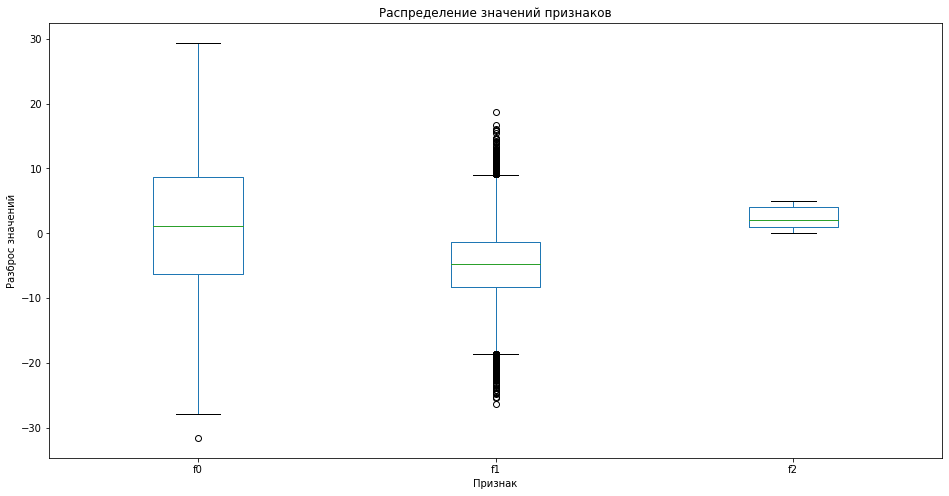

In [93]:
# построение боксплота для признаков f0, f1, f2
df_plot = df1.drop('product', axis=1)

fig, ax = plt.subplots(1)
ax.set_title('Распределение значений признаков')
ax.set_xlabel('Признак')
ax.set_ylabel('Разброс значений')
df_plot.plot(kind='box', figsize=(16,8), ax=ax)

Лучше отмасштабируем данные.

### Регион 2

In [94]:
df2 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на первые 10 строк датафрейма

In [95]:
df2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Изучим общую информацию о таблице

In [96]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


И посмотрим подробнее на основные параметры числовых характеристик

In [97]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Проверим, что все id встречаются по одному разу

In [98]:
id2_counts = df2['id'].value_counts()
id2_counts

VF7Jo    2
Vcm5J    2
xCHr8    2
KUPhW    2
BKgHH    1
        ..
vpF9g    1
5qafD    1
zgwIJ    1
tnIOc    1
rhWN2    1
Name: id, Length: 99996, dtype: int64

Странно, что некоторые id встречаются дважды. Посмотрим, что это за данные

In [99]:
df2['id'].mode()

0    KUPhW
1    VF7Jo
2    Vcm5J
3    xCHr8
dtype: object

In [100]:
strange_id2 = list(df2['id'].value_counts().loc[lambda x : x!=1].index)
strange_id2

['VF7Jo', 'Vcm5J', 'xCHr8', 'KUPhW']

In [101]:
df2.loc[df2['id'].isin(strange_id2)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Для одинаковых id разные значения. Это странно. Лучше удалим эти строки, поскольку они занимают не так много места.

In [102]:
df2 = df2.loc[~df2['id'].isin(strange_id2)]

В данном случае, поскольку модель учится на числовых признаках, столбец id можно убрать.

In [103]:
df2 = df2.drop('id', axis=1)

In [104]:
df2

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046
99996,-1.261523,-0.894828,2.524545,138.748846
99997,-1.199934,-2.957637,5.219411,157.080080
99998,-2.419896,2.417221,-5.548444,51.795253


Вернёмся к числовым признакам. Посмотрим на зависимость между величинами, чтобы понять, не нужно ли исключать какой-либо параметр

In [105]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.000501,-0.000454,-0.001974
f1,0.000501,1.000000,0.000763,-0.001046
f2,-0.000454,0.000763,1.000000,0.445873
product,-0.001974,-0.001046,0.445873,1.000000


Корреляции между f0, f1 и f0 не сильные. Оставляем все три параметра.

Посмотрим на разброс значений по признакам, чтобы понять, нужно ли масштабировать данные

<AxesSubplot:title={'center':'Распределение значений признаков'}, xlabel='Признак', ylabel='Разброс значений'>

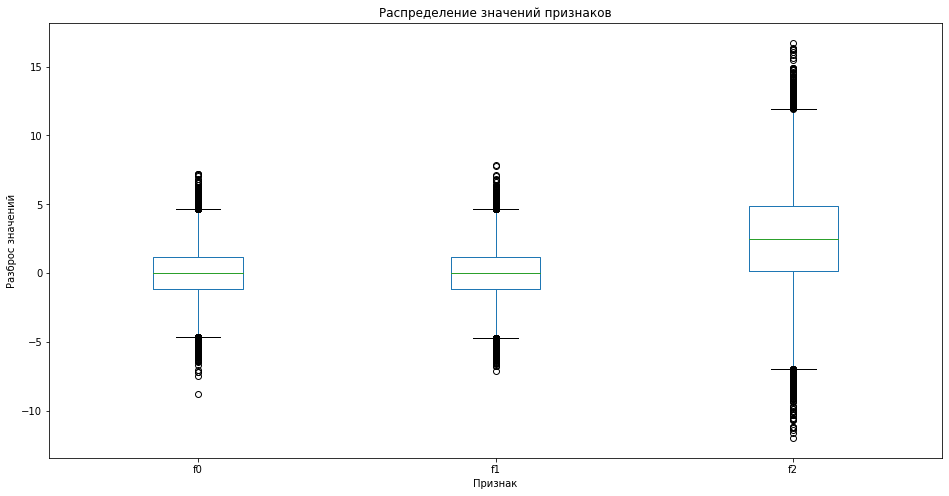

In [106]:
df2_plot = df2.drop('product', axis=1)

fig, ax = plt.subplots(1)
ax.set_title('Распределение значений признаков')
ax.set_xlabel('Признак')
ax.set_ylabel('Разброс значений')
df2_plot.plot(kind='box', figsize=(16,8), ax=ax)

Лучше отмасштабируем данные на всякий случай

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    

На данном этапе мы 
 * загрузили данные в отдельные переменные для каждого региона
 * убедились, что в данных нет пропусков и типы данных в столбцах соответствуют реальным значениям в таблицах
 * удалили из датафреймов те строки, в которых id повторяется
 * а затем удалили столбец id, поскольку он не понадобится для обучения модели
 * отметили, что будет полезно отмасштабировать данные
 * заметили в первом регионе сильную корреляцию между целевым признаком и параметром f2

## Обучение и проверка модели

Реализуем функцию деления на выборки

In [107]:
def split_train_valid(df):
    '''
    Функция принимает на вход таблицу.
    Выделяет в перемеенную target целевой признак, а в переменную features все остальные признаки.
    При помощи функции train_test_split делит данные на обучающую и валидационную выборки в соотношении 75:25.
    Возвращает 4 переменные - 2 для целевого признака на обеих выборках и 2 для остальных признаков
    '''
    target = df['product']
    features = df.drop('product', axis=1)
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42)
    return features_train, features_valid, target_train, target_valid

Применим написанную функцию к нашим данным

In [108]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_train_valid(df0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_train_valid(df1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_train_valid(df2)

Реализуем функцию стандартизации данных

In [109]:
def scaler_features(features_train, features_valid):
    '''
    Функция принимает на вход два параметра - признаки на обучающей выборке и признаки на валидационной выборке.
    Затем настраивает StandardScaler на обучающих данных
    и преобразовывает обучающую и валидационную выборки методом transform
    Возвращает функция, соответственно, преобразованные значения
    '''
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_scaled = scaler.transform(features_train)
    features_valid_scaled = scaler.transform(features_valid)
    return features_train_scaled, features_valid_scaled

Применим эту функцию к нашим данным

In [110]:
features_train_0, features_valid_0 = scaler_features(features_train_0, features_valid_0)
features_train_1, features_valid_1 = scaler_features(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scaler_features(features_train_2, features_valid_2)

Реализуем функцию для линейной регрессии

In [111]:
def linear_regression(features_train, features_valid, target_train, target_valid):
    '''
    Функция принимает на вход 4 параметра - признаки для обучающей и валидационной выборки и целевой признак для них же.
    Модель линейной регрессии обучается на обучающей выборке 
    и предсказанные для валидационной выборки значения созраняет в отдельной перенной, которую как раз и возвращает.
    Кроме того, функция считает rmse и среднее значение по предсказаниям. И выводит эти данные на экран.
    '''
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    predicted_mean = predicted_valid.mean()
    print('rmse =', rmse)
    print('predicted_mean =', predicted_mean)
    return predicted_valid

Применим эту функцию к данным

In [112]:
predicted_valid_0 = linear_regression(features_train_0, features_valid_0, target_train_0, target_valid_0)

rmse = 37.76114714593895
predicted_mean = 92.2865385223536


In [113]:
predicted_valid_1 = linear_regression(features_train_1, features_valid_1, target_train_1, target_valid_1)

rmse = 0.892863589877732
predicted_mean = 69.16894101447984


In [114]:
predicted_valid_2 = linear_regression(features_train_2, features_valid_2, target_train_2, target_valid_2)

rmse = 40.13115560413051
predicted_mean = 94.82069136328788


<div style="border:solid blue 2px; padding: 20px">

**Выводы**

 * Реализованы функции для разбиения данных на выборки, стандартизации данных и подсчёта rmse и среднегго значения для линейной регрессии.
 * Отчётливо заметна разница между регионом 1 и регионами 0 и 2. Для него ниже среднее предсказанное значение, но и средняя квадратичная ошибка (и, соответсвенно, корень из неё) тоже значительно меньше.

## Подготовка к расчёту прибыли

In [115]:
budget = 10000000000 # бюджет, выделенный на разработку скважен в регионе
revenue_per_item_of_product = 450000 # доход с единицы продукта
probability_limit_of_losses = 0.025 # порог для вероятности убытков
oil_production_points = 500 # количество исследуемых точек
best_oil_production_points = 200 # количество точек для разработки

Посчитаем, сколько нужно продуктов сырья для безубыточной разработки в регионе

In [116]:
# для этого разделим общий бюджет региона на выручку с единицы продукта сырья
min_product_region = budget / revenue_per_item_of_product
min_product_region

22222.222222222223

Рассчитаем, сколько нужно сырья для окупаемости скважины

In [117]:
# для этого прошлый результат разделим на количество точек для разработки
min_product_well = min_product_region / best_oil_production_points
min_product_well

111.11111111111111

Итак, чтобы проект не был убыточным, нужно как минимум 111 единиц продукта сырья в одной скважене. Полученный объём сырья больше среднего в каждом регионе. 

Реализуем функцию для расчёта прибыли в 200 наиболее прибыльных скважинах для региона. 

In [118]:
def revenue(target, probabilities):
    '''
    Функция получает на вход значения целевого признака и вероятности.
    Преобразует эти полученные значения в списки и сортирует вероятности по убыванию.
    Затем отбирает наиболее релевантные для неё значения 
    и возвращает выручку - сумму выбранных значений целевого признака, умноженную на выручку с одной единицы продукта минус размер бюджета
    '''
    probs_sorted = pd.Series(probabilities).reset_index(drop=True).sort_values(ascending=False)
    selected = pd.Series(target).reset_index(drop=True)[probs_sorted.index][:best_oil_production_points]
    result = selected.sum() * revenue_per_item_of_product - budget
    return result

Применим эту функцию для наших данных

In [119]:
print("Выручка для региона_0 =", revenue(target_valid_0, predicted_valid_0))

Выручка для региона_0 = 3301821343.6462536


In [120]:
print("Выручка для региона_1 =", revenue(target_valid_1, predicted_valid_1))

Выручка для региона_1 = 2415086696.681511


In [121]:
print("Выручка для региона_2 =", revenue(target_valid_2, predicted_valid_2))

Выручка для региона_2 = 2103914701.2991962


<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**

 * Реализована функция для расчёта прибыли по топ-200 скважинам региона
 * На данном этапе наиболее прибыльным кажется регион 0 - там выручка более 3 млрд рублей
 * Чтобы проект не был убыточным, скважины должны приносить более 111 единиц продукта сырья, однако средние значения по регионам не соответсвуют этой цифре

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона:
 * Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 * Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Зададим random state

In [122]:
state = np.random.RandomState(27)

Реализуем функцию для бутстрепа

In [123]:
def bootstrap(target, probabilities):
    '''
    Функция получает на вход значения целевого признака и вероятности.
    Создаёт переменную values, куда будет помещён список значений.
    Делает 1000 повторений, в ходе которых создаются подвыборки для бутстрепа с помощью фунции sample() с аргументом replace=True,
    поскольку один и тот же элемент может попасть в подвыборку несколько раз.
    Затем функция заполняет переменную values значениями выручки и после 1000 итераций выходит из цикла.
    После преобразует результат в Series и подсчитывает необходимые метрики - 2.5% квантиль, среднюю выручку, доверительный интервал и вероятность убытка
    '''
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=oil_production_points, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]     
        values.append(revenue(target_subsample, probs_subsample))
    values = pd.Series(values)

    lower = values.quantile(probability_limit_of_losses)

    mean = values.mean()
    
    confidence_interval = st.t.interval(alpha=0.95, df=len(values)-1, loc=values.mean(), scale=values.sem()) 
    risk_of_loss = values[values < 0].count() / values.count()
    print("Средняя выручка:", mean)
    print("2.5%-квантиль:", lower)
    print("Доверительный интервал:", confidence_interval)
    print("Вероятность убытка:", risk_of_loss)
    

Применим новую функцию к нашим данным

In [124]:
print("Регион 0:")
bootstrap(target_valid_0, predicted_valid_0)

Регион 0:
Средняя выручка: 394175905.98505646
2.5%-квантиль: -152359522.59835756
Доверительный интервал: (378159356.8359966, 410192455.1341163)
Вероятность убытка: 0.061


In [125]:
print("Регион 1:")
bootstrap(target_valid_1, predicted_valid_1)

Регион 1:
Средняя выручка: 489379426.9677513
2.5%-квантиль: 99520638.15919109
Доверительный интервал: (476780380.53699726, 501978473.3985054)
Вероятность убытка: 0.01


In [126]:
print("Регион 2:")
bootstrap(target_valid_2, predicted_valid_2)

Регион 2:
Средняя выручка: 357465950.9522644
2.5%-квантиль: -175551154.7933464
Доверительный интервал: (340943053.52499616, 373988848.3795327)
Вероятность убытка: 0.093


<div style="border:solid blue 2px; padding: 20px">

**Выводы**

 * Реализована функция для бутстрепа
 * В результате мы выяснили что
     * наибольшую среднюю выручку принесёт регион_1
     * кроме того, регион_1 имеет самую низкую вероятность убытков

## Общий вывод

В ходе работы над проектом были проделаны следующие вещи:
 * были изучен данные и выброшены из датасета странные значения id. Кроме того, сам столбец id так же был удалён
 * были стандартизованы признаки
 * была обучена модель линейной регрессии, показавшая значительную разницу между регионом_1 и регионами 0 и 2
 * была рассчитана прибыльность для каждого региона
 * была применена техника бутстрепа
 * и в результате был сделан вывод о том, что разрабатывать нужно регион_1, поскольку для него и средняя прибыль наибольшая и вероятность риска минимальная